# Doppler Velocity Dealiasing with Py-ART

In this notebook Doppler Velocity data from the ARM C-band SAPR radar is read using Py-ART and dealiased using BALTRAD.

## retrieve data from s3 bucket

In [1]:
import os
import urllib.request
from pathlib import Path

# Set the URL for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/erad2024/baltrad/pyart2baltrad"
!mkdir -p data
files = ["sgpcsaprppi_20110520095101.nc"]
for file in files:
    file0 = os.path.join(path, file)
    name = os.path.join("data", Path(file).name)
    if not os.path.exists(name):
        print(f"downloading, {name}")
        urllib.request.urlretrieve(f"{URL}{file0}", name)

downloading, data/sgpcsaprppi_20110520095101.nc


In [2]:
%matplotlib inline

Import the necessary modules

In [3]:
import pyart
import baltrad_pyart_bridge as bridge  # routines to pass data from Py-ART to BALTRAD
import _dealias  # BALTRAD's dealiasing module


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Read in the data using Py-ART

In [4]:
radar = pyart.io.read("data/sgpcsaprppi_20110520095101.nc")

Examine the velocity data using Py-ART Display object.

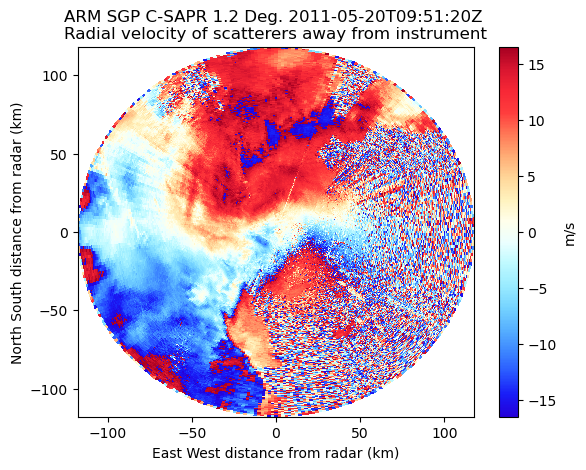

In [5]:
display = pyart.graph.RadarDisplay(radar)
nyquist_velocity = radar.instrument_parameters["nyquist_velocity"]["data"][0]
display.plot_ppi(
    "velocity", 1, colorbar_label="m/s", vmin=-nyquist_velocity, vmax=nyquist_velocity
)

Convert the radar data into a RaveIO object with the velocity data having the correct name.

In [6]:
vel_data = radar.fields["velocity"]["data"]
radar.add_field_like("velocity", "VRAD", vel_data)
rio = bridge.radar2raveio(radar)

Perform Doppler velocity dealiasing using BALTRAD.

In [7]:
ret = _dealias.dealias(rio.object)
print("This first scan is dealiased:"), _dealias.dealiased(rio.object.getScan(0))

This first scan is dealiased:


(None, False)

Add the dealiased velocity field to the origin Py-ART radar object.

In [8]:
temp = bridge.raveio2radar(rio)
if "dealiased_velocity" in radar.fields:
    radar.fields.pop("dealiased_velocity")
radar.add_field_like("velocity", "dealiased_velocity", temp.fields["VRAD"]["data"])

Plot the dealiased velocities.

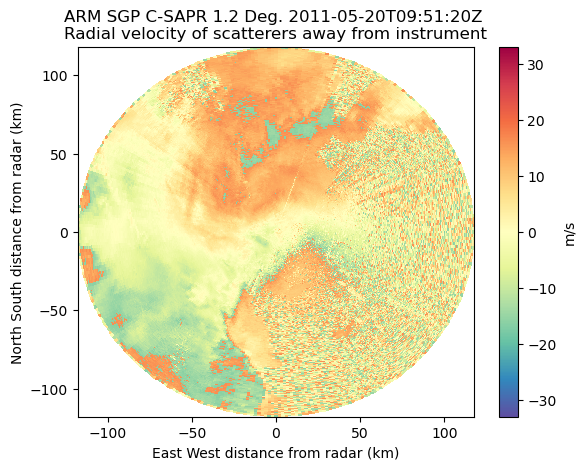

In [9]:
display.plot_ppi(
    "dealiased_velocity",
    1,
    colorbar_label="m/s",
    vmin=-2 * nyquist_velocity,
    vmax=2 * nyquist_velocity,
)